# ASC School: "Physics meets Artificial Intelligence"

## Tutorial: Variational Monte Carlo with neural quantum states for the Dynamics of the transverse-field Ising model

Filippo Vicentini, Giuseppe Carleo

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhilipVinc/Lectures/blob/main/2209_Munich/Dynamics.ipynb) 



In this Tutorial we will introduce the open-source package [NetKet](https://www.netket.org/), and show some of its functionalities. 
As this week has already been packed and you have already seen several advanced applications of Neural Networks Quantum States (With Roger Melko), we will give a brief overview of the fundamentals of NetKet, then move on how to determine the ground state of an Hamiltonian, and finally how to simulate the dynamics.

If you want to see a more 'slow-paced' and _in-depth_ tutorial only on determining the Ground State of an Hamiltonian, and about the different performance characteristics of different architectures, you can have a look at the tutorials on [NetKet's website](https://netket.readthedocs.io/en/latest/tutorials/gs-ising.html).

In This tutorial, we will study a Quench from the ground state of the 1-Dimensional Transverse-Field Ising Model for transverse field $ h=1 $ to transverse field $ h=2 $. 

$$ 
\mathcal{H}=\Gamma\sum_{i}\sigma_{i}^{(x)}+V\sum_{i}\sigma_{i}^{(z)}\sigma_{i+1}^{(z)}. 
$$

In the following we assume periodic boundary conditions and we will count lattice sites starting from $ 0 $, such that $ i=0,1\dots L-1 $ and $i=L=0$. 

In this tutorial we will consider only $L=10$ sites so that simulations run fast. However, you can easily scale those simulations up if you use a GPU or if you have some extra time. 

## 0. Installing Netket 

If you are executing this notebook on Colab, you will need to install NetKet (and some other dependencies). You can do so by running the following cell:

In [1]:
#%pip install --quiet netket==3.5

We also want make to sure that this notebook is running on the cpu. 
You can edit the field by changing "cpu" to "gpu" to make it run on the GPU if you want. 
But you'll need to use much larger systems to see a benefit in the runtime.
For systems with less than 40 spins GPUs slow you down remarkably.

In [2]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

You can check that the installation was succesfull doing:

In [3]:
!python3 -m netket.tools.info

/Library/Frameworks/Python.framework/Versions/3.8/bin/python3: Error while finding module specification for 'netket.tools.info' (ModuleNotFoundError: No module named 'netket')


In [4]:
# numerical operations in the model should always use jax.numpy 
# instead of numpy because jax supports computing derivatives. 
# If you want to better understand the difference between the two, check
# https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html
import jax.numpy as jnp

# Flax is a framework to define models using jax
import flax
# we refer to `flax.linen` as `nn`. It's a repository of 
# layers, initializers and nonlinear functions.
import flax.linen as nn

import numpy as np

import matplotlib.pyplot as plt

## 1. Defining the system and  Hamiltonian

The first step in our journey consists in defining the Hamiltonian we are interested in. 
For this purpose, we first need to define the kind of degrees of freedom we are dealing with (i.e. if we have spins, bosons, fermions etc). 
This is done specifying the Hilbert space of the problem. For example, let us concentrate on a problem with 20 spins-1/2.

When building hilbert spaces, in general, the first argument determines the size of the local basis and the latter defines how many modes you have.

In [5]:
import netket as nk

N = 10
hi = nk.hilbert.Spin(s=1 / 2, N=N)

NetKet's Hilbert spaces define the computational basis of the calculation, and are used to label and generate elements from it. 
The standard Spin-basis implicitly selects the `z` basis and elements of that basis will be elements $ v\in\{\pm 1\}^N $.

It is possible to generate random basis elements through the function `random_state(rng, shape, dtype)`, where the first argument must be a jax RNG state (usually built with `jax.random.PRNGKey(seed)`, second is an integer or a tuple giving the shape of the samples and the last is the dtype of the generated states.

In [6]:
import jax
hi.random_state(jax.random.PRNGKey(0), 3)

DeviceArray([[ 1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.],
             [ 1., -1.,  1., -1., -1.,  1., -1., -1., -1.,  1.],
             [-1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1.]],            dtype=float32)

We now need to specify the Hamiltonian. For this purpose, we will use NetKet's ```LocalOperator``` (see details [here](https://www.netket.org/docs/_generated/operator/netket.operator.LocalOperator.html#netket.operator.LocalOperator)) which is the sum of arbitrary k-local operators. 

In this specifc case, we have a 1-local operator, $ \sigma^{(x)}_i $ and a 2-local operator, $ \sigma^{(z)}_i \sigma^{(z)}_j $. We then start importing the pauli operators. 



In [7]:
from netket.operator.spin import sigmax, sigmaz 

We now take $ \Gamma=-1 $ and start defining the 1-local parts of the Hamiltonian 

In [8]:
Gamma = -1
H = sum([Gamma*sigmax(hi,i) for i in range(N)])

Here we have used a list comprehension to (mildly) show off our ability to write one-liners, however you could have just added the terms one by one in an explicit loop instead (though you'd end up with a whopping 3 lines of code). 

We now also add the interaction terms, using the fact that NetKet automatically recognizes products of local operators as tensor products. 

In [9]:
V=-1
H += sum([V*sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)])

In general, when manipulating NetKet objects, you should always assume that you can safely operate on them like 
you would in mathematical equations, therefore you can sum and multiply them with ease.

### 1b. Special Hamiltonians

For some specific Hamiltonians with a very specific structure, such as the Ising Hamiltonian, we can use a 'custom-made' implementation that is more performant. This implementation can only represent the Ising hamiltonian, and is of course less flexible than the mechanism above which allows us to write any (Local) hamiltonian.

To use this specific implementation, you need to define the graph over which we defined the model. In our case, that is the 1D periodic chain:

In [10]:
lattice = nk.graph.Chain(N)

Lattice(
    n_nodes=10,
    extent=[10],
    basis_vectors=
        [[1.]],
    site_offsets=
        [[0.]],
)



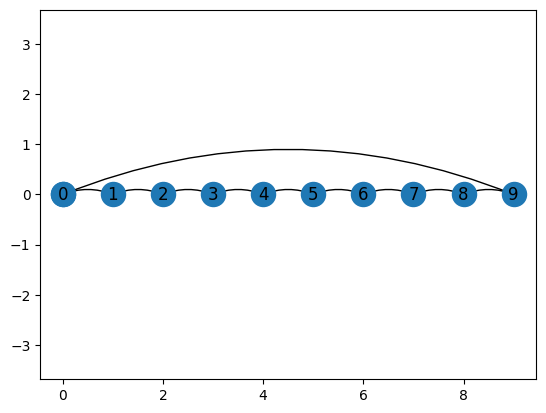

In [11]:
# We can also print it, or plot it in order to inspect it.
print(lattice);
lattice.draw();

And we can now build the custom Hamiltonian

In [12]:
?nk.operator.Ising

Init signature:
nk.operator.Ising(
    hilbert: netket.hilbert.abstract_hilbert.AbstractHilbert,
    graph: netket.graph.abstract_graph.AbstractGraph,
    h: float,
    J: float = 1.0,
    dtype: Any = None,
)
Docstring:     
The Transverse-Field Ising Hamiltonian :math:`-h\sum_i \sigma_i^{(x)} +J\sum_{\langle i,j\rangle} \sigma_i^{(z)}\sigma_j^{(z)}`.

This implementation is considerably faster than the Ising hamiltonian constructed by summing :class:`~netket.operator.LocalOperator` s.
Init docstring:
Constructs the Ising Operator from an hilbert space and a
graph specifying the connectivity.

Args:
    hilbert: Hilbert space the operator acts on.
    h: The strength of the transverse field.
    J: The strength of the coupling. Default is 1.0.
    dtype: The dtype of the matrix elements.

Examples:
    Constructs an ``Ising`` operator for a 1D system.

    >>> import netket as nk
    >>> g = nk.graph.Hypercube(length=20, n_dim=1, pbc=True)
    >>> hi = nk.hilbert.Spin(s=0.5, N=g.n_nod

In [13]:
H_special = nk.operator.Ising(hi, lattice, h=1.0, J=-1.0)

In [14]:
# And we can compare the two: if we check if they are equal, they are not, 
# because they are different implementations
H_special == H

# But if we compare their matrix versions, they do match:
import numpy as np
np.allclose(H_special.to_dense(), H.to_dense())

True

We can also get the Group of Translations or other symmetries of this lattice, if you're into group theory and simmetries...  but we won't be talking about that

In [15]:
lattice.translation_group()

PermutationGroup(elems=[Id(), Translation([1]), Translation([2]), Translation([3]), Translation([4]), Translation([5]), Translation([6]), Translation([7]), Translation([8]), Translation([9])], degree=10)

## 2. Exact Diagonalization

Now that we have defined the Hamiltonian, we can already start playing with it. For example, since the number of spins is large but still manageable for exact diagonalization, we can give it a try. 

In NetKet this is easily done converting our Hamiltonian operator into a sparse matrix of size $ 2^N \times 2^ N $. 

In [16]:
sp_h=H.to_sparse()
sp_h.shape

(1024, 1024)

Since this is just a regular scipy sparse matrix, we can just use any sparse diagonalization routine in there to find the eigenstates. For example, this will find the two lowest eigenstates  

In [17]:
from scipy.sparse.linalg import eigsh

eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")

print("eigenvalues with scipy sparse:", eig_vals)

E_gs = eig_vals[0]

eigenvalues with scipy sparse: [-12.78490644 -12.62750303]


## 3. Variational States: A RBM-NQS

In NetKet one has to define a variational function approximating the **logarithm** of the wave-function amplitudes (or density-matrix values).
We call this variational function _the Model_ (yes, caps on the M).

$$ \langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \exp\left[\mathrm{Model}(\sigma^{z}_1,\dots \sigma^{z}_N ; \theta ) \right], $$

where $\theta$ is a set of parameters. 
In this case, the parameter of the model will be just one: $\gamma$.  

The Model can be defined using one of the several *functional* jax frameworks such as Jax/Stax, Flax or Haiku. 
NetKet includes several pre-built models and layers built with [Flax](https://github.com/google/flax), so we will be using it for the rest of the notebook. 

In [18]:
# This only creates the 'definition' of the model, not the parameters themselves.
model = nk.models.RBM(alpha=1, param_dtype=complex)

The model itself is only a set of instructions on how to initialise the parameters and how to compute the result. 

In [19]:
# To initialize the parameters, you provide some 'mock' inputs:
pars = model.init(jax.random.PRNGKey(0), hi.numbers_to_states(np.arange(3)))

# and then we can evaluate it:
input = hi.random_state(jax.random.PRNGKey(3), 10)
logpsi_val = model.apply(pars, input)
print(f"An input of shape {input.shape=} gives output {logpsi_val.shape=}")

An input of shape input.shape=(10, 10) gives output logpsi_val.shape=(10,)


To actually create a variational state with its parameters, the easiest way is to construct a Monte-Carlo-sampled Variational State. 
To do this, we first need to define a sampler.

In `netket.sampler` several samplers are defined, each with its own peculiarities. 
In the following example, we will be using a simple sampler that flips the spins in the configurations one by one.

You can read more about how the sampler works by checking the documentation with `?nk.sampler.MetropolisLocal`

### 3a. Constructing the Variational State

In [20]:
# Create the local sampler on the hilbert space
sampler = nk.sampler.MetropolisLocal(hi, n_chains=8, n_sweeps=1)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sampler, model, n_samples=20*4000)

You can play around with the variational state: for example, you can compute expectation values yourself or inspect it's parameters.
The parameters are stored as a set of nested dictionaries. In this case, the single parameter $\lambda$ is stored inside a (frozen) dictionary.
(The reason why the dictionary is frozen is a detail of Flax).

In [21]:
print(vstate)
print(vstate.parameters)

MCState(hilbert = Spin(s=1/2, N=10), sampler = MetropolisSampler(rule = LocalRule(), n_chains = 8, n_sweeps = 1, reset_chains = False, machine_power = 2, dtype = float64), n_samples = 80000)
FrozenDict({
    Dense: {
        bias: DeviceArray([-3.79058600e-04-0.00867236j,  8.69396127e-03+0.00368896j,
                     -5.84870114e-05-0.00413436j,  3.52632987e-03-0.00627202j,
                     -4.44968245e-03-0.00190407j,  1.98786249e-02-0.00919453j,
                     -1.22735284e-02-0.01099211j,  2.46223408e-03+0.01231452j,
                     -4.83971309e-03-0.00193089j,  3.00957506e-03-0.00193304j],            dtype=complex128),
        kernel: DeviceArray([[-1.32912385e-03-4.79187956e-03j,
                      -6.15853081e-03+8.47503025e-03j,
                      -1.74893197e-02-2.90292006e-03j,
                      -7.05531102e-03-2.49925471e-03j,
                       1.06384874e-02-6.10633801e-03j,
                       8.98413291e-03+3.55382115e-03j,
             

### 3b. Computing expectation values

The **AllMighty** Giuseppe Carleo has shown you that, given a variational state

$$
\vert\psi_\theta\rangle = \sum_\sigma \psi_\theta(\sigma)\vert\sigma\rangle
$$

We can estimate expectation values in Polynomial time by writing them as:

\begin{align}
\langle \psi_\theta\vert \hat{H}\vert\psi_\theta \rangle &= \sum_\sigma \langle \psi_\theta\vert\sigma\rangle\langle\sigma\vert \hat{H}\vert\psi_\theta \rangle \\
&=  \sum_\sigma \langle \psi_\theta\vert\sigma\rangle\langle\sigma\vert\psi_\theta\rangle\frac{\langle\sigma\vert \hat{H}\vert\psi_\theta \rangle}{\langle\sigma\vert\psi_\theta\rangle} \\
&=  \sum_\sigma |\psi_\theta(\sigma)|^2H^{\text{Loc}}(\sigma) \\
&= \mathbb{E}_{\sigma\sim|\psi_\theta(\sigma)|^2}\left[H^{\text{Loc}}(\sigma)\right]
\end{align}

With a variational state, you can compute expectation values of operators using `vstate.expect`. For our `MCState`, this internally performs Monte Carlo sampling over `n_samples` spin configurations.

In [22]:
# let's generate the samples
σ = vstate.sample()
print(f"My samples have {σ.shape = } which comes from {vstate.sampler.n_chains = } ",
      "chains of 10'000 samples each, and an hilbert space of {hi.size=} spins.")

# we can also inspect the acceptance rate:
print("The acceptance rate right now is stored in the `sampler_state`: ", vstate.sampler_state)

My samples have σ.shape = (10000, 8, 10) which comes from vstate.sampler.n_chains = 8  chains of 10'000 samples each, and an hilbert space of {hi.size=} spins.
The acceptance rate right now is stored in the `sampler_state`:  

MetropolisSamplerState(accepted = 142648/144000 (99.06%), rng state=[1680913857  311322740])


In [23]:
# Let's generate the local energies
H_loc = vstate.local_estimators(H)
print(f"My local estimators have a shape of {H_loc.shape = }. The samples are taken from `vstate.samples`, which are the last sampled samples.")

My local estimators have a shape of H_loc.shape = (8, 10000). The samples are taken from `vstate.samples`, which are the last sampled samples.


In [24]:
# Let's compute the expectation value:
print("<H> =", jnp.mean(H_loc), "Var[H] = ", jnp.var(H_loc), "\n")

# But a much better way to compute it would be: 
nk.stats.statistics(H_loc)

<H> = (-9.97077820741907-0.00021556527804404065j) Var[H] =  10.121465035289496 



-9.971-0.000j ± 0.023 (σ²=10.121, R̂=1.00)

All that was done above, can be done much more quickly and coincisely by running:

In [25]:
vstate.n_samples = 4000
E = vstate.expect(H)
print(type(E))
print(E)

<class 'netket.stats.mc_stats.Stats'>


-9.878+0.001j ± 0.097 (σ²=9.988, R̂=1.01)


The return value of `.expect` is an object of type `Stats` which, beside the energy expectation value contains some statistics of the ensemble of local energies over which the energy is estimated.

The `Stats` object also has a dictionary representation:

In [26]:
print(E.to_dict())

{'Mean': (-9.878134804812133+0.0013409130154285642j), 'Variance': 9.988077702994948, 'Sigma': 0.09672753704551139, 'R_hat': 1.008523310627868, 'TauCorr': 1.3734768993808075}


The `Stats` object contains the following diagnostics:

* The `Mean` over the local energy samples, which is an estimate of the quantum expectation value $\langle \hat H \rangle.$

* The `Variance` over the local energy samples, which is an estimate of the quantum variance $\langle(\delta\hat H)^2\rangle = \langle (\hat H - \langle \hat H \rangle)^2 \rangle.$

* The Monte Carlo standard error (MCSE) of the mean (as `Sigma`).

* An estimate `TauCorr` of the autocorrelation time over the Markov chains.

* `R_hat`, which is the so-called Gelman-Rubin split-R_hat diagnostic, which indicates whether the MCMC chain is converged (see below).

If you are close to an eigenstate of the operators, the variance should be close to 0. (In an exact eigenstate, the local energy is constant and therefore the variance is exactly zero.)

The Gelman-Rubin diagnostic will be $\hat{R}\approx 1$ if the Markov chains are converged, while it will be larger than $1$ if your sampling has not converged.
As a rule of thumb, look out for $|\hat{R}| > 1.1$, and if that occurs consistently, check if you need more samples or if you MCMC scheme is even consistent with your system. (This is a somewhat weak criterion. Modern MCMC literature tends to recommend $|\hat{R}| > 1.01$ to discard a sample. NQS optimization can still work with the less stringent criterion, but if you see stability problems, keep this in mind.)

You can also investigate the correlation time of your estimator, $\tau$. If $\tau\gg1$ then your samples are very correlated and you most likely have some issues with your sampling scheme.

You can also access the fields individually:
Note that if you run your calculation using MPI on different processes/machines, those estimators will return the mean, error and estimators of all the samples across all the processes.

### 3c. Computing gradients of Expectation values

Above we have computed the expectation value as:

\begin{align}
\langle \psi_\theta\vert \hat{H}\vert\psi_\theta \rangle &=   \sum_\sigma |\psi_\theta(\sigma)|^2H^{\text{Loc}}(\sigma) \\
&= \mathbb{E}_{\sigma\sim|\psi_\theta(\sigma)|^2}\left[H^{\text{Loc}}(\sigma)\right]
\end{align}

But... in order to use an optimisation algorithm such as gradient descent, we will need to compute the gradient of this quantity as well. 
For an expectation value, it is easy to derive the formula:

$$
    \nabla_\theta \mathbb{E}_{X\sim p_\theta(X)}\left[ f_\theta(X) \right] = \mathbb{E}_{X\sim p_\theta(X)}\left[\nabla_\theta f_\theta(X) \right]- \mathbb{E}_{X\sim p_\theta(X)}\left[(\nabla_\theta\log\psi_\theta(X))f_\theta(X) \right]
$$

Which, translated to our case, gives:

\begin{align}
\nabla_\theta \langle \psi_\theta\vert \hat{H}\vert\psi_\theta \rangle = \\
&= 2\Re\left\{\mathbb{E}_{\sigma\sim|\psi_\theta(\sigma)|^2}\left[(\nabla_\theta\log\psi(\sigma)) H^{\text{Loc}}(\sigma)\right] - \mathbb{E}_{\sigma\sim|\psi_\theta(\sigma)|^2}\left[\nabla_\theta\log\psi(\sigma)\right] \mathbb{E}_{\sigma\sim|\psi_\theta(\sigma)|^2}\left[H^{\text{Loc}}(\sigma)\right] \right\} \,\,\,\, &&\text{If parameters are real} \\
&= \mathbb{E}_{\sigma\sim|\psi_\theta(\sigma)|^2}\left[(\nabla_\theta\log\psi(\sigma)) H^{\text{Loc}}(\sigma)\right] - \mathbb{E}_{\sigma\sim|\psi_\theta(\sigma)|^2}\left[\nabla_\theta\log\psi(\sigma)\right] \mathbb{E}_{\sigma\sim|\psi_\theta(\sigma)|^2}\left[H^{\text{Loc}}(\sigma)\right] \,\,\,\, &&\text{If parameters are complex}
\end{align}

Now, as we showed before, the parameters in NetKet are not stored as a single array/vector $\vec{\theta} = \{\theta_1, \theta_2, \dots\theta_N\}$, but rather as a PyTree, which is a set of nested dictionaries containing arbirarily shaped matrices, tensors and scalars which, overall, behave as arrays:

In [34]:
jax.tree_map(lambda x: (x.shape, x.dtype), vstate.parameters)

FrozenDict({
    Dense: {
        bias: ((10,), dtype('complex128')),
        kernel: ((10, 10), dtype('complex128')),
    },
    visible_bias: ((10,), dtype('complex128')),
})

So we will want the gradient to have the same shape...

I will not show you how to do it by hand (because it's a bit involved, but you can have a look [here](https://github.com/netket/netket/blob/77a23dcdc42b63f0116510e1064e82351f830fb0/netket/vqs/mc/mc_state/expect_forces.py#L67) if you really are curious.
Instead, NetKet allows you to compute the gradient directly and efficiently by calling the function 

```
vstate.expect_and_grad(operator)
```

In [35]:
E, grad_E = vstate.expect_and_grad(H)

jax.tree_map(lambda x: (x.shape, x.dtype), grad_E)

FrozenDict({
    Dense: {
        bias: ((10,), dtype('complex128')),
        kernel: ((10, 10), dtype('complex128')),
    },
    visible_bias: ((10,), dtype('complex128')),
})

Lets look at how the statistics work a bit more closely. We'll be using some artifically generated random data:

In [36]:
import numpy as np

# generate some random values from a standard normal distribution
xs = np.random.normal(size=1000)
print(xs[:10])

[ 1.38280338  0.40302189  1.65100645 -0.43905558  0.65195273 -1.13763403
 -1.23334237  1.47041252  0.19384075  1.08849175]


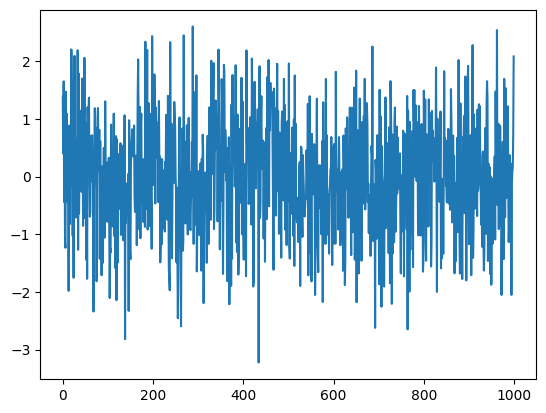

In [37]:
import matplotlib.pyplot as plt

plt.plot(xs)

In [38]:
import seaborn as sns
import arviz

ModuleNotFoundError: No module named 'arviz'

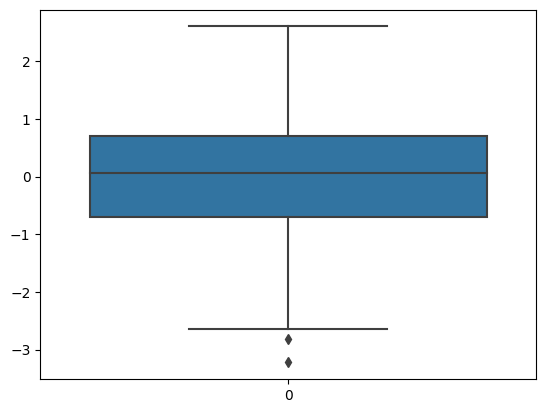

In [39]:
sns.boxplot(data=xs.T);

In [ ]:
nk.stats.statistics(xs)

How does the error of the mean scale with the number of samples?

In [ ]:
n_samples = 5 * 10**np.arange(1, 8)
print(n_samples)

In [ ]:
mcerrors = [nk.stats.statistics(np.random.normal(size=n)).error_of_mean for n in n_samples]
plt.plot(n_samples, mcerrors)
plt.plot(n_samples, 1/np.sqrt(n_samples), "k--")
plt.loglog()

As is well known from MC theory, the error decreases proportionally to $1/\sqrt{N_\mathrm{samples}}.$

But this is Markov chain Monte Carlo. How do we actually know whether our chain is already converged to the correct distribution? There could be insufficient burn-in or our chain is stuck in one part of the probability distribution and gives a biased estimate?

Typical solution in MCMC: Run several independent chains (its more efficient anyways) and compare their estimates.

For examples, let's generate several Gaussian "chains":

In [32]:
def show_chains(data):
    _, axs = plt.subplots(1, data.shape[0], figsize=(16, 3), sharey=True)
    for i, row in enumerate(data):
        axs[i].plot(row)
    plt.show()
    sns.boxplot(data=data.T)
    plt.show()
    
    stats = nk.stats.statistics(xs)
    print("stats:         ", stats)

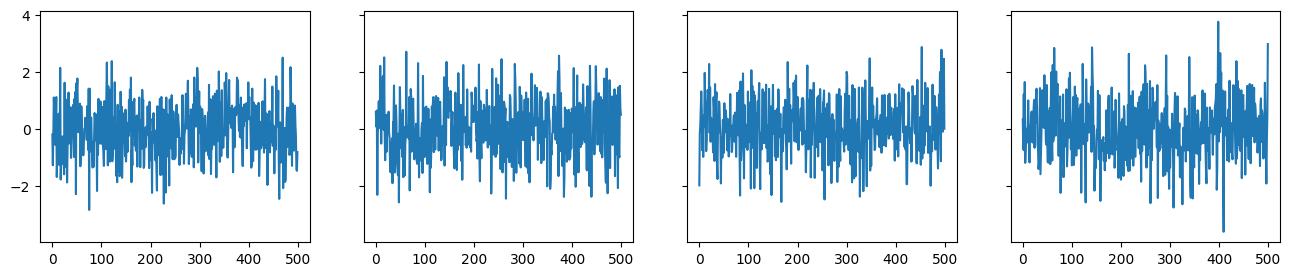

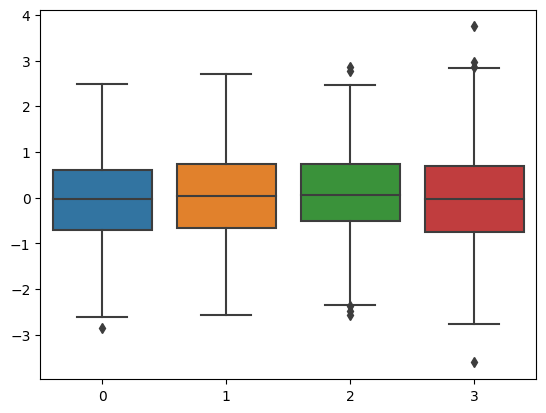

stats:          

0.009 ± 0.024 (σ²=0.981, R̂=1.00)


In [33]:
xs = np.array([
    np.random.normal(size=500),
    np.random.normal(size=500),
    np.random.normal(size=500),
    np.random.normal(size=500),
])
show_chains(xs)

Let's see what happens if something goes wrong. Say, one chain disagrees with the others on the correct mean:

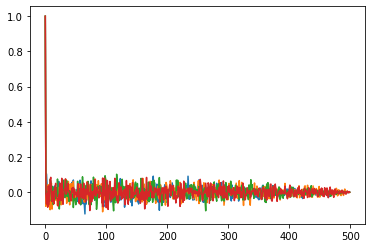

In [27]:
c = arviz.autocorr(xs)
plt.plot(c.T);

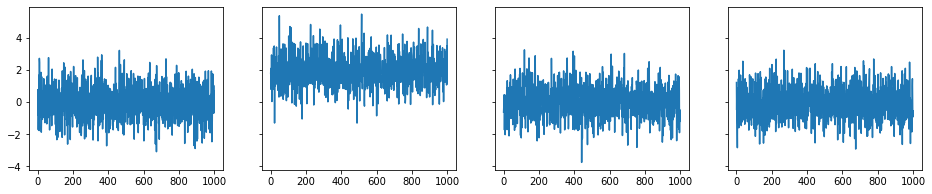

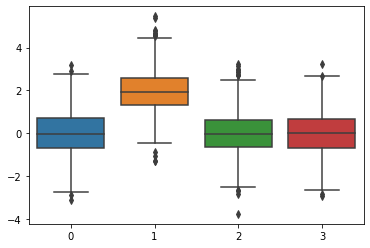

stats:          0.486 ± 0.077 [σ²=1.709, R̂=1.1973]


In [28]:
xs = np.array([
    np.random.normal(size=1000),
    np.random.normal(size=1000) + 2,
    np.random.normal(size=1000),
    np.random.normal(size=1000),
])
show_chains(xs)

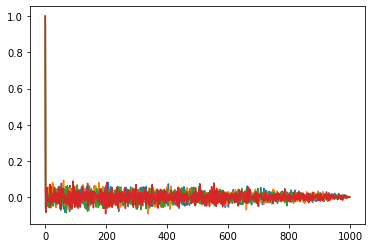

In [29]:
c = arviz.autocorr(xs)
plt.plot(c.T);

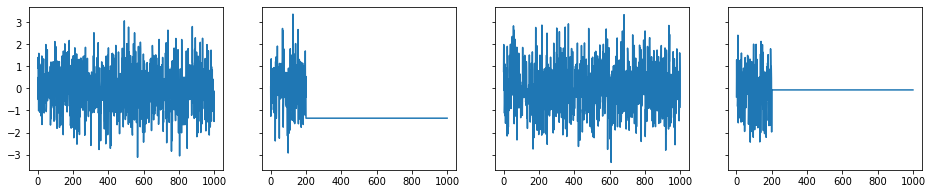

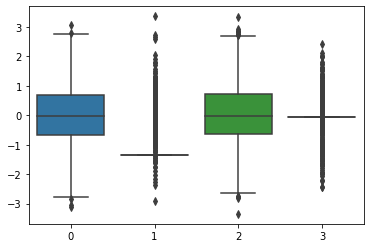

stats:          -0.287 ± 0.048 [σ²=0.905, R̂=1.1175]


In [34]:
xs = np.array([
    np.random.normal(size=1000),
    np.random.normal(size=1000),
    np.random.normal(size=1000),
    np.random.normal(size=1000),
])
xs[1, 200:] = xs[1, 200]
xs[3, 200:] = xs[2, 200]
show_chains(xs)

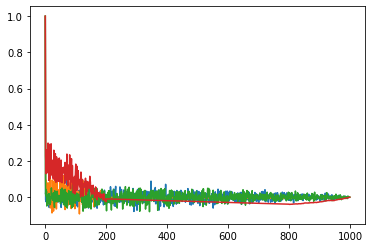

In [31]:
c = arviz.autocorr(xs)
plt.plot(c.T);

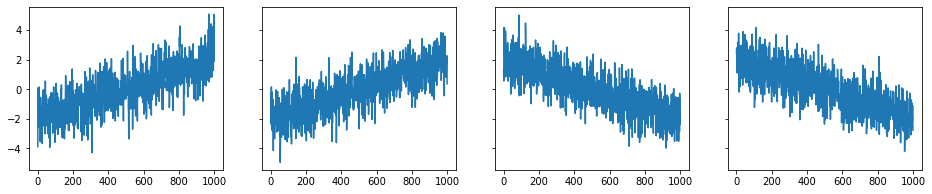

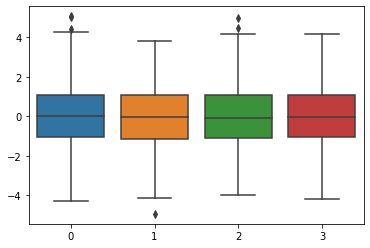

stats:          -0.01 ± 0.10 [σ²=2.29, R̂=1.1963]


In [35]:
xs = np.array([
    np.random.normal(size=1000),
    np.random.normal(size=1000),
    np.random.normal(size=1000),
    np.random.normal(size=1000),
])
xs[:2] += 2*np.linspace(-1, 1, 1000)
xs[2:] -= 2*np.linspace(-1, 1, 1000)
show_chains(xs)

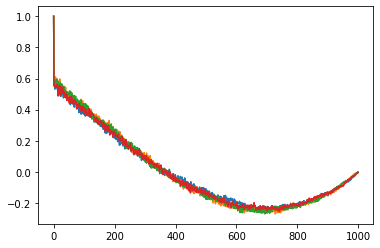

In [36]:
c = arviz.autocorr(xs)
plt.plot(c.T);

Getting back to our VMC example, let's try out a couple of `n_samples` values and see what happens to the energy statistics:

In [37]:
print("n_samples   E")
for n_samples in [32, 64, 128, 512, 1024, 2048, 4096, 2**16, 2**17, 2**18]:
    vstate.n_samples = n_samples
    E = vstate.expect(H)
    print(f"{n_samples:>5}      {E}")

n_samples   E
   32      -19.50 ± 0.70 [σ²=15.74, R̂=1.1143]
   64      -19.81 ± 0.58 [σ²=21.74, R̂=1.0600]
  128      -19.84 ± 0.38 [σ²=18.86, R̂=1.0328]
  512      -20.12 ± 0.20 [σ²=19.71, R̂=1.0074]
 1024      -19.88 ± 0.15 [σ²=19.40, R̂=1.0084]
 2048      -20.152 ± 0.096 [σ²=19.994, R̂=1.0006]
 4096      -19.961 ± 0.067 [σ²=19.340, R̂=1.0003]
65536      -19.995 ± 0.019 [σ²=20.209, R̂=1.0001]
131072      -20.010 ± 0.012 [σ²=19.947, R̂=1.0000]
262144      -20.0060 ± 0.0087 [σ²=19.9751, R̂=1.0000]


In [38]:
def show_many_chains(data, nx, ny):
    _, axs = plt.subplots(nx, ny, figsize=(20, 6), sharex=True, sharey=True)
    axs = axs.ravel()
    for i, row in enumerate(data):
        axs[i].plot(row)
    plt.show()
    plt.figure(figsize=(20, 3))
    sns.boxplot(data=data.T)
    plt.show()
    
    stats = nk.stats.statistics(data)
    print("stats:         ", stats)

In [41]:
from functools import partial

In [42]:
theta = vstate.variables

@partial(jax.vmap, in_axes=0)
@partial(jax.vmap, in_axes=0)
def local_energy(sigma, sigmap, mels):
    logpsi_s = mf_model.apply(theta, sigma)
    def term(sp, mel):
        return jnp.exp((mf_model.apply(theta, sp) - logpsi_s)) * mel
    return jnp.sum(jax.vmap(term)(sigmap, mels))

In [72]:
vstate.sampler = nk.sampler.MetropolisLocal(hi, n_chains=8, n_sweeps=1)
vstate.n_samples = 4000 * 20

In [77]:
vstate.reset()
s, (sp, mels) = nk.vqs.get_local_kernel_arguments(vstate, H)
eloc = local_energy(s, sp, mels).T
print(eloc.shape)

(8, 10000)


In [78]:
nk.stats.statistics(eloc)

-19.960 ± 0.052 [σ²=20.125, R̂=1.0006]

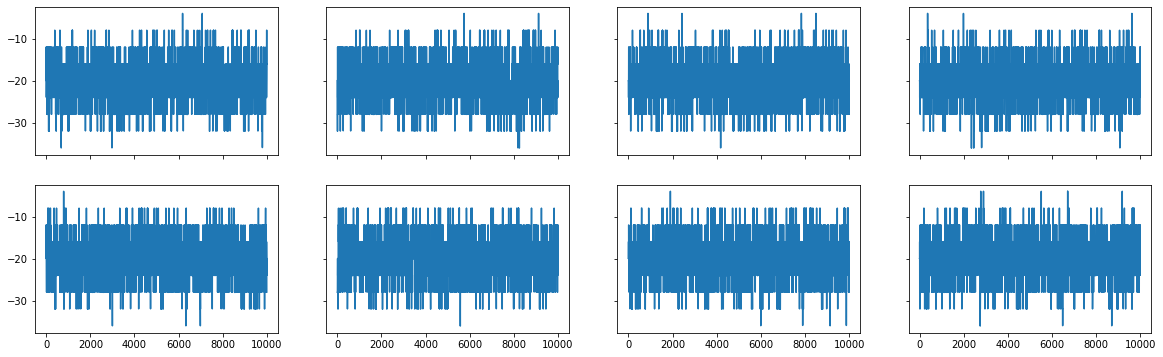

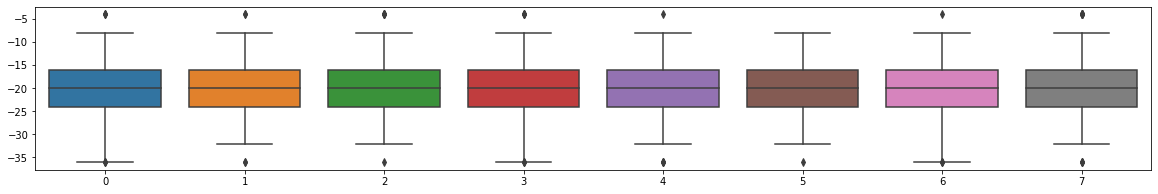

stats:          -19.960 ± 0.052 [σ²=20.125, R̂=1.0006]


In [79]:
show_many_chains(eloc, 2, 4)

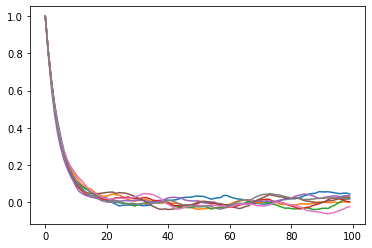

In [80]:
c = arviz.autocorr(eloc)
plt.plot(c.T[:100]);

## 4. Variational Monte Carlo

We will now try to optimise $ \lambda $ in order to best approximate the ground state of the hamiltonian.

At first, we'll try to do this by ourself by writing the training loop, but then we'll switch to using a pre-made
solution provided by netket for simplicity.

### 4a. DIY Optimisation loop

The optimisation (or training) loop must do a very simple thing: at every iteration it must compute the energy and it's gradient, then multiply the gradient by a certain learning rate $\lambda = 0.05$ and lastly it must update the parameters with this rescaled gradient.
You can do so as follows:

In [40]:
from tqdm import tqdm

energy_history = []
n_steps = 100

# For every iteration (tqdm is just a progress bar)
for i in tqdm(range(n_steps)):
    # compute energy and gradient of the energy
    E, E_grad = vstate.expect_and_grad(H)
    # log the energy to a list
    energy_history.append(E.mean.real)
    # equivalent to vstate.parameters - 0.05*E_grad , but it performs this
    # function on every leaf of the dictionaries containing the set of parameters
    new_pars = jax.tree_map(lambda x,y: x-0.05*y, vstate.parameters, E_grad)
    # actually update the paramters
    vstate.parameters = new_pars

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.95it/s]


We now can plot the energy during those optimisation steps:


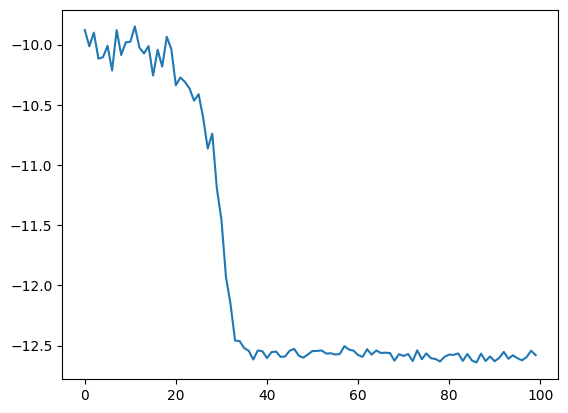

In [42]:
plt.plot(energy_history)

### 4b. Use NetKet's optimisation driver 

As writing the whole optimisation loop by yourself every time is.. boring, we can make use of a coupled of NetKet's built-in utilities.

In [48]:
# First we reset the parameters to run the optimisation again
vstate.init_parameters()

# Then we create an optimiser from the standard library.
# You can also use optax.
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

# build the optimisation driver
gs = nk.driver.VMC(H, optimizer, variational_state=vstate)

# Use one of the NetKet's internal loggers
log = nk.logging.RuntimeLog()

# run the driver for 300 iterations. This will display a progress bar
# by default.
gs.run(n_iter=300, out=log)

mf_energy=vstate.expect(H)
error=abs((mf_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",mf_energy,error)

(99.3%) ━━━━━━━━━━━━━━━━━━━━━╸ 298/300 [ 0:00:36>0:00:01 • 0.1s/it • Energy =               ]
                                                                     -12.771+0.000j ± 0.014  
                                                                     (σ²=0.169, R̂=1.01)

Optimized energy and relative error:  

-12.757-0.007j ± 0.011 (σ²=0.122, R̂=1.01) 0.00226109067116552


In [45]:
eig_vals[0]

-12.78490644299933

In [52]:
log.data['Energy']

History(
   keys  = ['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], 
   iters = [0, 1, ... 298, 299] (300 steps),
)

Text(0, 0.5, 'Energy')

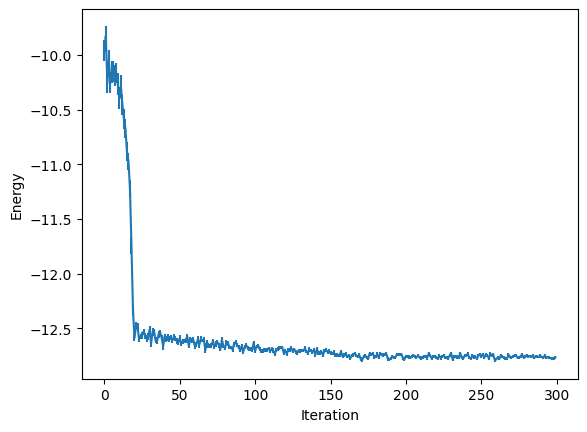

In [63]:
plt.errorbar(log.data['Energy'].iters, log.data['Energy'].Mean.real, yerr=log.data['Energy'].Sigma);
plt.xlabel("Iteration")
plt.ylabel("Energy")
#plt.yscale('log')

## 5. Dynamics! 

Let's try to do dynamics. Starting from the ground state at $h=1$ . 

To be safe, let's store our starting parameters (so that we can always reset them).
In Jax/Flax/NetKet arrays and parameters are immutable, meaning that you can **never** modify them in-place. So storing them here is safe.

In [ ]:
θ_0 = vstate.parameters

Now let's define the parameters of the simulation we want to run, so that we can generate some exact data to benchmark against

In [86]:
H_quench = nk.operator.Ising(hi, lattice, h=0.5, J=1.0)

t0 = 0.0
t_end = 2.0

# observables
Sx = sum([nk.operator.spin.sigmax(hi, i) for i in range(hi.size)])/hi.size

### 5a. Exact solution

Let's now use [QuTiP](https://qutip.org/) to solve the equation exactly.
To convert NetKet's objects to QuTiP you can just call `.to_qobj()` on them. Remember that QuTiP scales exponentially, as it does calculations in the full Hilbert space.

In [87]:
import qutip as qt

#Schroedinger-Equation-SOLVE
sol = qt.sesolve(H_quench.to_qobj(), vstate.to_qobj(), np.arange(t0, t_end, 0.01), e_ops=[Sx.to_qobj()])

Text(0, 0.5, 'Sigma X')

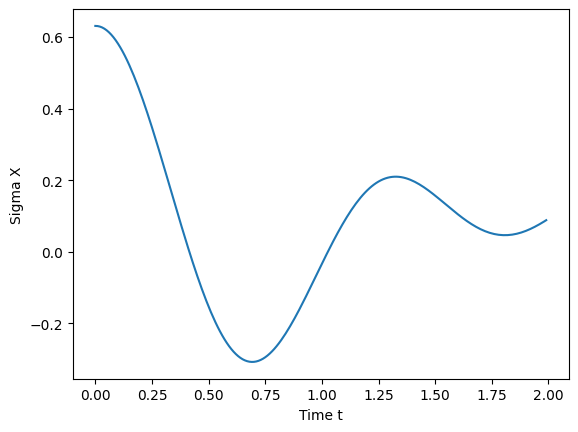

In [88]:
plt.plot(sol.times, sol.expect[0])
plt.xlabel("Time t")
plt.ylabel("Sigma X")

### 5b. TDVP

Let's now use the TDVP.

You have heard in the lecture by the AllMighty how to do time evolution on a variational ansatz.
Otherwise, helpful references for the derivation of the TDVP equations of motion are, e.g, Yuan et al. (Quantum 3, 191, 2019), and Stokes et al. (arXiv:2203.14824).

We assume to have parameters $\theta$ with mapping $\theta \mapsto \psi_\theta.$
In order to evolve the variational ansatz $$(\theta, s) \mapsto \psi_\theta(s)$$, we can locally optimize the fidelity
$$
    \max_{\delta\theta} |\langle \mathrm{e}^{-\gamma \hat H \delta t} \psi_{\theta} | \psi_{\theta + \delta\theta} \rangle|^2.
$$
Taylor expanding this condition to second order in $\delta\theta$ and $\delta t$ yields after some steps the equation of motion
$$
G(\theta) \, \dot\theta = -\gamma F(\theta, t)
$$
with the quantum geometric tensor
$$
    G_{ij}(\theta) = \frac{
       \langle\partial_i\psi_\theta | \partial_j\psi_\theta\rangle
    }{
       \langle \psi_\theta | \psi_\theta \rangle
    } - \frac{
       \langle\partial_i\psi_\theta | \psi_\theta \rangle\langle \psi_\theta | \partial_j\psi_\theta\rangle
    }{
       \langle \psi_\theta | \psi_\theta \rangle^2
    }
$$and gradient $$ F_i(\theta, t) = \frac{\partial\langle \hat H \rangle}{\partial\theta_i^*}$$
$\gamma = 1$ results in imaginary time evolution, $\gamma = \mathrm i$ gives real time evolution instead.

$G$ and $F$ can be estimated using Monte Carlo sampling: Given $s \sim |\psi_\theta(s)|^2$, we can estimate those quantities by
$$
    G_{ij} = \operatorname{cov}(o_i, o_j)
    \qquad
    F_i = \operatorname{cov}(o_i, h)
$$
whith the local energy
$$
h(s) = \frac{\langle s | \hat H | \psi_\theta \rangle}{\langle s | \psi_\theta \rangle}
    = \sum_{s'} \frac{\psi_\theta(s')}{\psi_\theta(s)} \langle s | \hat H | s' \rangle
$$
and "quantum score function"
$$
    o_j(s) = \frac{\partial\ln\psi_\theta(s)}{\partial\theta_j}.
$$

In NetKet, the quantum geometric tensor $S_\theta$ is available from the variational state class:

In [89]:
vstate.quantum_geometric_tensor()

QGTOnTheFly(diag_shift=0.0)

This object behaves like a matrix that can be multiplied by the vector of parameters:

In [91]:
#vstate.quantum_geometric_tensor() @ vstate.parameters

In [ ]:
So the only thing we need is now: